# A training example in Pytorch
## Introduction
### Task
In this notebook we will train a neural network to do a simple task. This will be a classification task : as explained in the first week of lectures, classification basically means to find a *decision boundary* over a space of real numbers. For representation purposes we will work with a 2D example : the decision boundary will be a cercle. More precisely, it will be the unit circle in the plan.
![](unitycircle.png)
### Sampling
We will generate points $(x_1,x_2)$ to classify, and their class $y$. The actual decision fonction is $y=1_{x_1^2+x_2^2<1}$.

To have a balanced dataset with about as many points in each class, we will sample uniformly over polar coordinates,  within the circle of center 0 and radius 2.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
print(torch.__version__)
%matplotlib inline

0.4.1


In [2]:
def sample_points(n):
    # returns (X,Y), where X of shape (n,2) is the numpy array of points and Y is the (n) array of classes
    
    radius = np.random.uniform(low=0,high=2,size=n).reshape(-1,1) # uniform radius between 0 and 2
    angle = np.random.uniform(low=0,high=2*np.pi,size=n).reshape(-1,1) # uniform angle
    x1 = radius*np.cos(angle)
    x2=radius*np.sin(angle)
    y = (radius<1).astype(int).reshape(-1)
    x = np.concatenate([x1,x2],axis=1)
    return x,y

In [3]:
# Generate the data
trainx,trainy = sample_points(10000)
valx,valy = sample_points(500)
testx,testy = sample_points(500)

print(trainx.shape,trainy.shape)

(10000, 2) (10000,)


Our model will be a multi-layer perceptron with one hidden layer, and an output of size 2 since we have two classes. Since it is a binary classification task we could also use just one output and a zero threshold, but we will use two to illustrate the use of the pytorch Cross-Entropy loss (with one output, you would use BinaryCrossEntropy).

As you know from the lectures, such a model cannot represent a circular boundary but could represent a polygonal boundary, whose number of sides is the number of neurons on the hidden layer. For example, with 6 hidden neurons the model could compute a hexagonal boundary that approximate the unity circle, such as :
![](hexagon.png)

Of course the trained model won't compute an actual hexagone, due to the activation that isn't a threshold, and the liberty of the final layer's weights (it does not have to be an AND). We can actually expect *better* accuracy than what a hexagon could do.

In [4]:
def generate_single_hidden_MLP(n_hidden_neurons):
    return nn.Sequential(nn.Linear(2,n_hidden_neurons),nn.ReLU(),nn.Linear(n_hidden_neurons,2))
model1 = generate_single_hidden_MLP(6)

To train our model, we will need to feed it with tensors. Let's transform our generated numpy arrays :

In [5]:
trainx = torch.from_numpy(trainx).float()
valx = torch.from_numpy(valx).float()
testx = torch.from_numpy(testx).float()

trainy = torch.from_numpy(trainy).long()
valy = torch.from_numpy(valy).long()
testy = torch.from_numpy(testy).long()
print(trainx.type(),trainy.type())

torch.FloatTensor torch.LongTensor


Now we will define our training routine. There is the question of whether to perform our traing on CPU or GPU. The best thing to do is to use a flag variable that you will set, when you actually do the training.

In [6]:
def training_routine(net,dataset,n_iters,gpu):
    # organize the data
    train_data,train_labels,val_data,val_labels = dataset
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(),lr=0.01)
    
    # use the flag
    if gpu:
        train_data,train_labels = train_data.cuda(),train_labels.cuda()
        val_data,val_labels = val_data.cuda(),val_labels.cuda()
        net = net.cuda() # the network parameters also need to be on the gpu !
        print("Using GPU")
    else:
        print("Using CPU")
    for i in range(n_iters):
        # forward pass
        train_output = net(train_data)
        train_loss = criterion(train_output,train_labels)
        # backward pass and optimization
        train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # Once every 100 iterations, print statistics
        if i%100==0:
            print("At iteration",i)
            # compute the accuracy of the prediction
            train_prediction = train_output.cpu().detach().argmax(dim=1)
            train_accuracy = (train_prediction.numpy()==train_labels.cpu().numpy()).mean() 
            # Now for the validation set
            val_output = net(val_data)
            val_loss = criterion(val_output,val_labels)
            # compute the accuracy of the prediction
            val_prediction = val_output.cpu().detach().argmax(dim=1)
            val_accuracy = (val_prediction.numpy()==val_labels.cpu().numpy()).mean() 
            print("Training loss :",train_loss.cpu().detach().numpy())
            print("Training accuracy :",train_accuracy)
            print("Validation loss :",val_loss.cpu().detach().numpy())
            print("Validation accuracy :",val_accuracy)
    
    net = net.cpu()

In [7]:
dataset = trainx,trainy,valx,valy

In [8]:
gpu = True
gpu = gpu and torch.cuda.is_available() # to know if you actually can use the GPU
begin = time.time()
training_routine(model1,dataset,10000,gpu)
end=time.time()

Using GPU
At iteration 0
Training loss : 0.6987106204032898
Training accuracy : 0.5003
Validation loss : 0.7039246559143066
Validation accuracy : 0.486
At iteration 100
Training loss : 0.677510678768158
Training accuracy : 0.4203
Validation loss : 0.6795798540115356
Validation accuracy : 0.402
At iteration 200
Training loss : 0.6638249158859253
Training accuracy : 0.5779
Validation loss : 0.6638974547386169
Validation accuracy : 0.562
At iteration 300
Training loss : 0.6521827578544617
Training accuracy : 0.6372
Validation loss : 0.6509451270103455
Validation accuracy : 0.608
At iteration 400
Training loss : 0.6414715051651001
Training accuracy : 0.6623
Validation loss : 0.6396153569221497
Validation accuracy : 0.65
At iteration 500
Training loss : 0.6312623620033264
Training accuracy : 0.6757
Validation loss : 0.6290354132652283
Validation accuracy : 0.672
At iteration 600
Training loss : 0.6213157176971436
Training accuracy : 0.6864
Validation loss : 0.6188277006149292
Validation acc

At iteration 5700
Training loss : 0.1571037620306015
Training accuracy : 0.9703
Validation loss : 0.1503140926361084
Validation accuracy : 0.974
At iteration 5800
Training loss : 0.15441352128982544
Training accuracy : 0.9711
Validation loss : 0.1479216367006302
Validation accuracy : 0.97
At iteration 5900
Training loss : 0.15184079110622406
Training accuracy : 0.9717
Validation loss : 0.145643949508667
Validation accuracy : 0.968
At iteration 6000
Training loss : 0.14939665794372559
Training accuracy : 0.9717
Validation loss : 0.14346875250339508
Validation accuracy : 0.968
At iteration 6100
Training loss : 0.14706821739673615
Training accuracy : 0.9721
Validation loss : 0.14139312505722046
Validation accuracy : 0.968
At iteration 6200
Training loss : 0.14484672248363495
Training accuracy : 0.9724
Validation loss : 0.13942237198352814
Validation accuracy : 0.968
At iteration 6300
Training loss : 0.14271709322929382
Training accuracy : 0.9724
Validation loss : 0.13753719627857208
Valid

In [9]:
print("Training time :",end-begin)

Training time : 24.634289741516113


In [10]:
# Let's try with 3 hidden neurons.
model2 = generate_single_hidden_MLP(3) 
training_routine(model2,dataset,10000,gpu)

Using GPU
At iteration 0
Training loss : 0.8042043447494507
Training accuracy : 0.5003
Validation loss : 0.8238264322280884
Validation accuracy : 0.486
At iteration 100
Training loss : 0.7185286283493042
Training accuracy : 0.5003
Validation loss : 0.7303446531295776
Validation accuracy : 0.486
At iteration 200
Training loss : 0.6989850401878357
Training accuracy : 0.3706
Validation loss : 0.7071495652198792
Validation accuracy : 0.346
At iteration 300
Training loss : 0.6923447251319885
Training accuracy : 0.387
Validation loss : 0.6988030672073364
Validation accuracy : 0.358
At iteration 400
Training loss : 0.6878220438957214
Training accuracy : 0.4534
Validation loss : 0.6936196684837341
Validation accuracy : 0.418
At iteration 500
Training loss : 0.682556688785553
Training accuracy : 0.5406
Validation loss : 0.6881617307662964
Validation accuracy : 0.512
At iteration 600
Training loss : 0.6763601899147034
Training accuracy : 0.5856
Validation loss : 0.6821454763412476
Validation acc

At iteration 5700
Training loss : 0.45156118273735046
Training accuracy : 0.7756
Validation loss : 0.47905534505844116
Validation accuracy : 0.76
At iteration 5800
Training loss : 0.4514290392398834
Training accuracy : 0.7755
Validation loss : 0.4790177643299103
Validation accuracy : 0.76
At iteration 5900
Training loss : 0.45129701495170593
Training accuracy : 0.7752
Validation loss : 0.47899454832077026
Validation accuracy : 0.76
At iteration 6000
Training loss : 0.4511772096157074
Training accuracy : 0.7755
Validation loss : 0.47897839546203613
Validation accuracy : 0.76
At iteration 6100
Training loss : 0.45107242465019226
Training accuracy : 0.775
Validation loss : 0.47897568345069885
Validation accuracy : 0.758
At iteration 6200
Training loss : 0.4509792923927307
Training accuracy : 0.7752
Validation loss : 0.4789806306362152
Validation accuracy : 0.756
At iteration 6300
Training loss : 0.4508935511112213
Training accuracy : 0.7757
Validation loss : 0.47898975014686584
Validation

In [11]:
out = model2(testx).argmax(dim=1).detach().numpy()
green = testx.numpy()[np.where(out==1)]
red = testx.numpy()[np.where(out==0)]
print(green.shape,red.shape)

(288, 2) (212, 2)


In [12]:
def print_model(model,datapoints):
    out = model(datapoints).argmax(dim=1).detach().numpy()
    green = datapoints.numpy()[np.where(out==1)]
    red = datapoints.numpy()[np.where(out==0)]

    circle1 = plt.Circle((0, 0), 1, color='y')
    circle2 = plt.Circle((0, 0), 1, color='b',fill=False)

    fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
    # (or if you have an existing figure)
    # fig = plt.gcf()
    # ax = fig.gca()
    plt.xlim((-2,2))
    plt.ylim((-2,2))

    pos_values = plt.scatter(x=green[:,0],y=green[:,1], color='g',)
    neg_values = plt.scatter(x=red[:,0],y=red[:,1], color='r',)

    ax.add_artist(circle1)
    ax.add_artist(circle2)
    ax.add_artist(pos_values)
    ax.add_artist(neg_values)

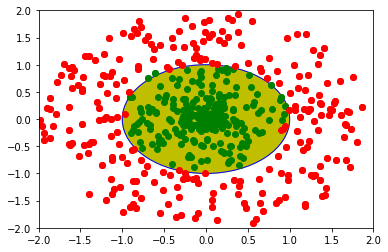

In [13]:
print_model(model1,testx)

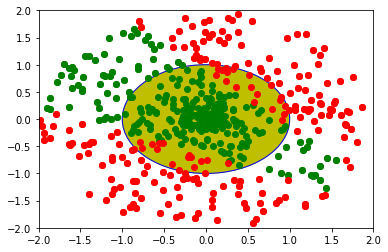

In [14]:
print_model(model2,testx)

In [15]:
model3 = generate_single_hidden_MLP(2) 
training_routine(model3,dataset,10000,gpu)

Using GPU
At iteration 0
Training loss : 0.757908821105957
Training accuracy : 0.5003
Validation loss : 0.7690756320953369
Validation accuracy : 0.486
At iteration 100
Training loss : 0.7138646841049194
Training accuracy : 0.5003
Validation loss : 0.7210879921913147
Validation accuracy : 0.486
At iteration 200
Training loss : 0.6944175958633423
Training accuracy : 0.5003
Validation loss : 0.6991903781890869
Validation accuracy : 0.486
At iteration 300
Training loss : 0.6836276054382324
Training accuracy : 0.5003
Validation loss : 0.6868808269500732
Validation accuracy : 0.486
At iteration 400
Training loss : 0.6757462024688721
Training accuracy : 0.5003
Validation loss : 0.6780419945716858
Validation accuracy : 0.486
At iteration 500
Training loss : 0.6687736511230469
Training accuracy : 0.5142
Validation loss : 0.6704592108726501
Validation accuracy : 0.49
At iteration 600
Training loss : 0.6619855761528015
Training accuracy : 0.6194
Validation loss : 0.663285493850708
Validation accu

At iteration 5700
Training loss : 0.4545077979564667
Training accuracy : 0.7835
Validation loss : 0.45250192284584045
Validation accuracy : 0.788
At iteration 5800
Training loss : 0.4542773962020874
Training accuracy : 0.7835
Validation loss : 0.45235541462898254
Validation accuracy : 0.79
At iteration 5900
Training loss : 0.4540669023990631
Training accuracy : 0.7828
Validation loss : 0.4522089660167694
Validation accuracy : 0.79
At iteration 6000
Training loss : 0.45387357473373413
Training accuracy : 0.7823
Validation loss : 0.4520772397518158
Validation accuracy : 0.79
At iteration 6100
Training loss : 0.4536908268928528
Training accuracy : 0.7819
Validation loss : 0.451982706785202
Validation accuracy : 0.79
At iteration 6200
Training loss : 0.4535170793533325
Training accuracy : 0.7818
Validation loss : 0.45192718505859375
Validation accuracy : 0.79
At iteration 6300
Training loss : 0.45335546135902405
Training accuracy : 0.7822
Validation loss : 0.45187908411026
Validation accur

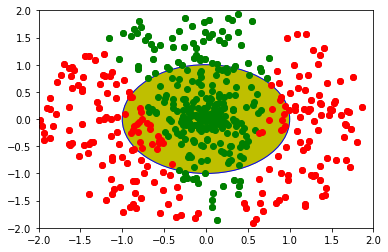

In [16]:
print_model(model3,testx)